### **Positive and negative sentence classification model in 2, 3 and 4 star review comments**

In [1]:
%%capture
!pip install -r ../requirements.txt

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import unicodedata
import fasttext
import re
import nltk
import pickle
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.cluster.util import cosine_distance
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn import model_selection, svm
from sklearn.svm import SVC
from sklearn.metrics import silhouette_score, classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer

In [3]:
df_raw = pd.read_csv('../data/raw/Big_AHR.csv')

In [4]:
df_3_stars = df_raw[df_raw['rating']==3]

In [15]:
for text in df_3_stars['review_text'].sample(5).tolist():
    print(text)
    print()

Está bien situado, aunque las calles de alrededor son muy sucias...por la noche se oía ruido de la calle. Tuvimos bichos en la habitación, aunque el personal fumigó y nos ofreció el cambio la situación fue algo desagradable. Aun así, tiene buen precio y buen desayuno (merece la pena cogerlo).

La ubicación es perfecta, entra el acceso a la Alcazaba y la Catedral. Puedes recorrer todo el centro e ir a la playa de la Malagueta y la zona del MuelleUno andando. El parking está a escasos metros y el acceso al mismo y las plazas son correctos. La habitación daba a un patio interior y era tranquila. El hotel está algo antiguo, pero cumple para una estancia de ciudad. Alrededor hay muchos establecimientos para desayunar, comer y cenar.

La posada Doña Lupe se puede ver de muchas maneras. No es un lugar para estarse en las habitaciones, ya que éstas sólo sirven para dormir y gracias. Está poco cuidado (faltaban muchas bombetas, por ejemplo) y se podría decir que la limpieza era la justa. Aún as

In this sample of neutral reviews, it can be seen that the comments highlight both positive and negative aspects.
Therefore, each comment will be separated into sentences, with the aim of being classified as positive or negative.

The division of each comment into sentences and the text processing was done *using create_df_sentences.py*

In [3]:
df_sentences_1_star = pd.read_csv('../data/interim/sentences_1_star.csv')
df_sentences_5_stars = pd.read_csv('../data/interim/sentences_5_stars.csv')

All sentences belonging to 5-star reviews will be assumed to be positive, and all sentences belonging to 1-star reviews will be assumed to be negative. While this is not strictly true, it will allow the model to be built.

In [6]:
len(df_sentences_1_star)

11885

In [7]:
len(df_sentences_5_stars)

53205

In [8]:
# Take a sample of positive sentences to equate both categories
df_sentences_5_stars = df_sentences_5_stars.sample(len(df_sentences_1_star))

In [9]:
print('Examples of negative sentences:')
df_sentences_1_star.sample(3)

Examples of negative sentences:


,text,review_index,text_processed
8647,Simplemente querían cobrar un extra a lo pacta...,1_1292,simplemente querian cobrar extra pactado trave...
11682,"Tanto recorte me parece una verguenza, apagar ...",1_1647,recorte parece verguenza apagar aire acondicio...
11123,"Limpieza de las habitaciones la minima, camas ...",1_1578,limpieza habitaciones minima camas estrechas


In [10]:
print('Examples of positive sentences:')
df_sentences_5_stars.sample(3)

Examples of positive sentences:


,text,review_index,text_processed
15211,"Buen hotel Urbano, incluso con una pequeña pis...",5_2687,buen urbano incluso pequena piscina refrescarse
11037,"A pocos metros de las atracciones de Malaga, s...",5_1966,pocos metros atracciones malaga encuentra remo...
10587,"Viaje por trabajo, el hotel está bien ubicado ...",5_1893,viaje trabajo bien ubicado confort excepcional


In [4]:
# Add column to indicate sentiment
df_sentences_1_star['label'] = 'Negative'
df_sentences_5_stars['label'] = 'Positive'

In [12]:
# Combine positive and negative sentences into one df
df_sentences_labeled = pd.concat([df_sentences_1_star, df_sentences_5_stars]).reset_index(drop=True)

In [13]:
df_sentences_labeled['label'] = df_sentences_labeled['label'].astype('category')

In [14]:
# Delete empty rows
df_clean = df_sentences_labeled[df_sentences_labeled.text_processed.notna()]

##### **Training and evaluation of the model for sentences classification**

In [15]:
X = df_clean['text_processed']
y = df_clean['label']

In [16]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, random_state=18)

In [17]:
classifier = Pipeline([
    ('count_vectorizer', CountVectorizer(max_features=1000, ngram_range=(1,2))),
    ('tfidf', TfidfTransformer()),
    ('model', SVC(kernel='rbf', probability=True))
])

In [18]:
classifier.fit(X_train, y_train)

Pipeline(steps=[('count_vectorizer',
                 CountVectorizer(max_features=1000, ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('model', SVC(probability=True))])

In [19]:
y_pred = classifier.predict(X_val)

In [20]:
classifier.score(X_train, y_train)

0.9325753719101759

In [21]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

    Negative       0.85      0.89      0.87      2935
    Positive       0.89      0.84      0.86      2958

    accuracy                           0.87      5893
   macro avg       0.87      0.87      0.87      5893
weighted avg       0.87      0.87      0.87      5893



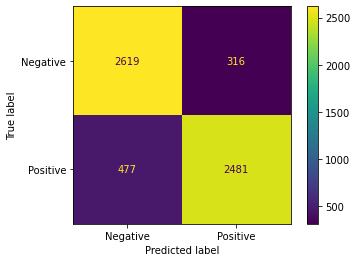

In [22]:
cm = confusion_matrix(y_val, y_pred, labels=classifier.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
disp.plot()
plt.show()

In [23]:
# Save model
filename = '../models/sentences_classification.pkl'
pickle.dump(classifier, open(filename,'wb'))

In [3]:
# Load model
classifier = pickle.load(open('../models/sentences_classification.pkl', 'rb'))

##### **Application of the model to sentences corresponding to 2-star reviews**

In [4]:
df_sentences_2_stars = pd.read_csv('../data/interim/sentences_2_stars.csv')

In [5]:
df_2_stars = df_sentences_2_stars[df_sentences_2_stars.text_processed.notna()]
X_2_stars = df_2_stars['text_processed']
y_2_stars = classifier.predict(X_2_stars)
df_y_2_stars = pd.DataFrame({'label':y_2_stars})
predictions_2_stars = pd.concat([df_2_stars, df_y_2_stars], axis=1).reset_index(drop=True)


In [18]:
predictions_2_stars.sample(5)

,text,review_index,text_processed,label
5849,Un mal hostal en una buena situación,2_835,mal hostal buena situacion,Negative
5283,Las paredes de la habitacion necesitan una man...,2_773,paredes habitacion necesitan mano pintura bast...,Negative
1071,Y es que a través del sistema de ventilación s...,2_158,traves sistema ventilacion cuela humo tabaco h...,Negative
926,Injusta relación Calidad - precio,2_136,injusta relacion calidad precio,Positive
3888,A favor la ubicación del hostal que se encuent...,2_567,favor ubicacion hostal encuentra escasos dos k...,Positive


In [6]:
predictions_2_stars.label.value_counts()

Negative    5404
Positive    1779
Name: label, dtype: int64

In [20]:
print(f'Predicted percentage of negative sentences: {round((100*5404)/(5404+1779))}%')
print(f'Predicted percentage of positive sentences: {round((100*1779)/(5404+1779))}%')

Predicted percentage of negative sentences: 75%
Predicted percentage of positive sentences: 25%


##### **Application of the model to sentences corresponding to 3-star reviews**

In [31]:
df_sentences_3_stars = pd.read_csv('../data/interim/sentences_3_stars.csv')

In [32]:
df_3_stars = df_sentences_3_stars[df_sentences_3_stars.text_processed.notna()]
X_3_stars = df_3_stars['text_processed']
y_3_stars = classifier.predict(X_3_stars)
df_y_3_stars = pd.DataFrame({'label':y_3_stars})
predictions_3_stars = pd.concat([df_3_stars, df_y_3_stars], axis=1).reset_index(drop=True)

In [40]:
predictions_3_stars.sample(5)

,text,review_index,text_processed,label
1147,"Imposible dormir, mal aisladas las habitacione...",3_191,imposible dormir mal aisladas habitaciones ven...,Negative
7371,Ubicación extraordinaria pero falta de honesti...,3_1198,ubicacion extraordinaria falta honestidad publ...,Negative
13431,"La ubicación del hotel no es céntrica, hay que...",3_2096,ubicacion no centrica ir plaza donante sangre ...,Negative
12461,Acabamos de llegar del hotel,3_1990,acabamos llegar,Positive
11975,La limpieza no es la mejor,3_1919,limpieza no mejor,Negative


In [41]:
predictions_3_stars.label.value_counts()

Negative    7448
Positive    7294
Name: label, dtype: int64

In [42]:
print(f'Predicted percentage of negative sentences: {round((100*7448)/(7448+7294))}%')
print(f'Predicted percentage of positive sentences: {round((100*7294)/(7448+7294))}%')

Predicted percentage of negative sentences: 51%
Predicted percentage of positive sentences: 49%


##### **Application of the model to sentences corresponding to 4-star reviews**

In [37]:
df_sentences_4_stars = pd.read_csv('../data/interim/sentences_4_stars.csv')

In [38]:
df_4_stars = df_sentences_4_stars[df_sentences_4_stars.text_processed.notna()]
X_4_stars = df_4_stars['text_processed']
y_4_stars = classifier.predict(X_4_stars)
df_y_4_stars = pd.DataFrame({'label':y_4_stars})
predictions_4_stars = pd.concat([df_4_stars, df_y_4_stars], axis=1).reset_index(drop=True)

In [45]:
predictions_4_stars.sample(5)

,text,review_index,text_processed,label
15093,"El desayuno muy bien, camareros agradables y a...",4_2637,desayuno bien camareros agradables atentos ofr...,Positive
12605,"Por otra parte, el desayuno de 10, por 3 euros...",4_2209,parte desayuno 10 3 euros aprox tostada impres...,Positive
11582,Desayuno completo,4_2022,desayuno completo,Positive
3387,"Buena relación precio/calidad, el personal es ...",4_627,buena relacion precio calidad personal amable ...,Positive
12538,Limpieza,4_2196,limpieza,Positive


In [46]:
predictions_4_stars.label.value_counts()

Positive    19024
Negative     6191
Name: label, dtype: int64

In [2]:
print(f'Predicted percentage of negative sentences: {round((100*6191)/(19024+6191))}%')
print(f'Predicted percentage of positive sentences: {round((100*19024)/(19024+6191))}%')

Predicted percentage of negative sentences: 25%
Predicted percentage of positive sentences: 75%


##### **Create datasets of positive and negative sentences**

Negative sentences

In [56]:
df_negative_sentences = pd.concat([df_sentences_1_star, predictions_2_stars[predictions_2_stars['label']=='Negative'], predictions_3_stars[predictions_3_stars['label']=='Negative'], predictions_4_stars[predictions_4_stars['label']=='Negative']])

In [57]:
df_negative_sentences = df_negative_sentences[df_negative_sentences.text_processed.notna()]

In [59]:
df_negative_sentences.to_csv('../data/processed/negative_sentences.csv')

Positive sentences

In [60]:
df_positive_sentences = pd.concat([df_sentences_5_stars, predictions_2_stars[predictions_2_stars['label']=='Positive'], predictions_3_stars[predictions_3_stars['label']=='Positive'], predictions_4_stars[predictions_4_stars['label']=='Positive']])

In [61]:
df_positive_sentences = df_positive_sentences[df_positive_sentences.text_processed.notna()]

In [62]:
df_positive_sentences.to_csv('../data/processed/positive_sentences.csv')